## pycontrails Basics

Introduction to running flight data through contrail models with ERA5 meteorology.

<a target="_blank" href="https://colab.research.google.com/github/contrailcirrus/2024-09-ge-workshop/blob/main/pycontrails-basics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# Run in colab
!pip install pycontrails

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from pycontrails import Flight, MetDataset, DiskCacheStore

In [2]:
BUCKET = "contrails-301217-2024-10-ge-workshop"
SOURCE = f"gs://{BUCKET}"
CACHE = DiskCacheStore(cache_dir="cache")

CONUS = (-125, -65, 22, 48)        # CONUS extend (W, E, S, N)
DATE = pd.Timestamp("2019-02-01")  # Date of interest

## Download example flight data

In [3]:
# Download flights file from GCP
# This file contains 100 flights in the US
df = pd.read_parquet(f"{SOURCE}/flights/{DATE.strftime('%Y%m%d')}.pq")

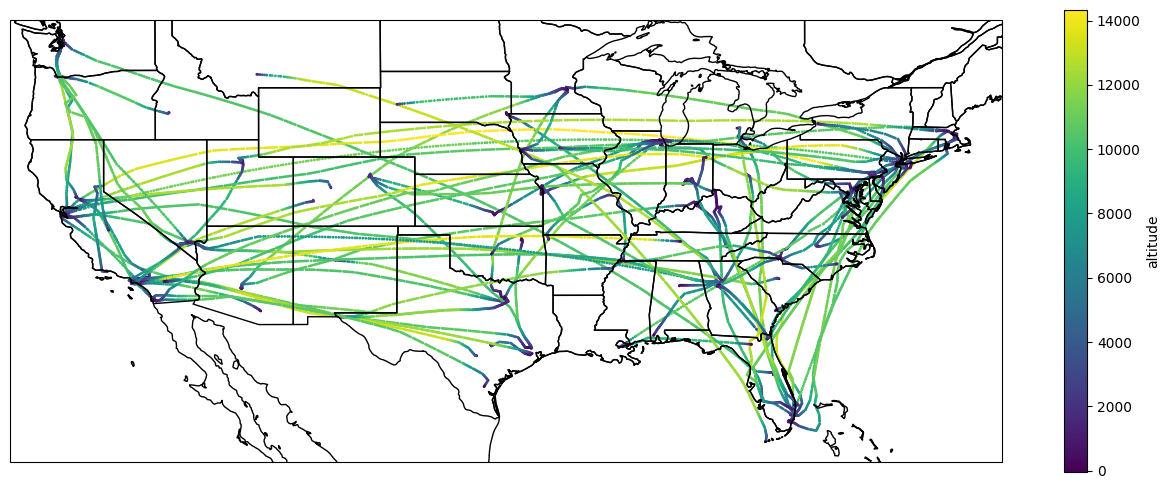

In [4]:
# Show all flights on map
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

# plot flight waypoints with color showing altitude
df.plot.scatter(
    x="longitude", 
    y="latitude", 
    c="altitude",
    s=1, 
    ax=ax, 
    transform=ccrs.PlateCarree(),
    legend=False
);

In [5]:
# Select example flight and create a pycontrails `Flight` object
# https://py.contrails.org/api/pycontrails.Flight.html#pycontrails.Flight
flight = Flight(df[df["flight_id"] == "190201-100870-DAL2791"])
flight

Flight [6 keys x 149 length, 1 attributes]
	Keys: flight_id, waypoint, longitude, latitude, altitude, ..., time
	Attributes:
	time                [2019-02-01 21:24:46, 2019-02-01 23:22:23]
	longitude           [-122.733, -115.152]
	latitude            [36.08, 47.527]
	altitude            [132.0, 10363.2]
	crs                 EPSG:4326

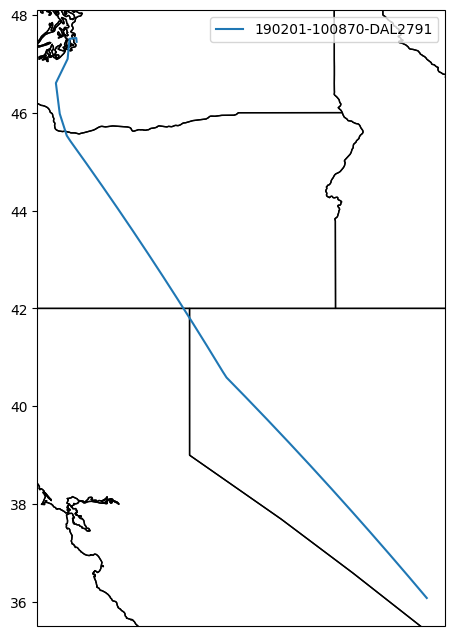

In [6]:
# Plot single flight
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

# use the `.dataframe` accessor to get the underlying pandas dataframe back out
flight.dataframe.plot(
    x="longitude",
    y="latitude",
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    label=flight["flight_id"][0]
);

## Download meteorology

In [9]:
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip # Use to define necessary meteorology variables

In [10]:
# Set the bounds for meteorology data
time_bounds = (DATE, DATE + pd.Timedelta("36h"))
pressure_levels = (350, 300, 250, 225, 200, 175, 150)

# Download pressure level data
era5pl = ERA5(
    time=time_bounds,
    variables=Cocip.met_variables,
    pressure_levels=pressure_levels,
    cachestore=CACHE
)

# Download single leveel data (in this case radiation esimates)
era5sl = ERA5(
    time=time_bounds, 
    variables=Cocip.rad_variables,
    cachestore=CACHE
)

In [ ]:
# Save time by downloading met from pre-cached data in the SOURCE bucket
!gsutil -m rsync {SOURCE}/cache ./cache

In [11]:
# Download data from ERA5 (or open from cache)
# Note if you have downloaded data in the past, you may have to update your CDS credentials
# See https://cds.climate.copernicus.eu/how-to-api
met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

## Calculate Schmidt-Appleman Criterion (SAC) along flight waypoints

[pycontrails.models.sac](https://py.contrails.org/api/pycontrails.models.sac.html)

In [12]:
from pycontrails.models.sac import SAC
from pycontrails.models.humidity_scaling import ExponentialBoostLatitudeCorrectionHumidityScaling

In [13]:
# SAC model inputs
# https://py.contrails.org/api/pycontrails.models.sac.html#pycontrails.models.sac.SACParams
params = {
    "humidity_scaling": ExponentialBoostLatitudeCorrectionHumidityScaling()
}

# Set up model
sac = SAC(
    met=met,
    params=params
)

# Run model
fl_sac = sac.eval(source=flight)

In [14]:
# Analyze rezults, e.g. 
# Get the length of the Flight in the SAC region (in km)
fl_sac.length_met("sac") / 1e3

1156.27162041895

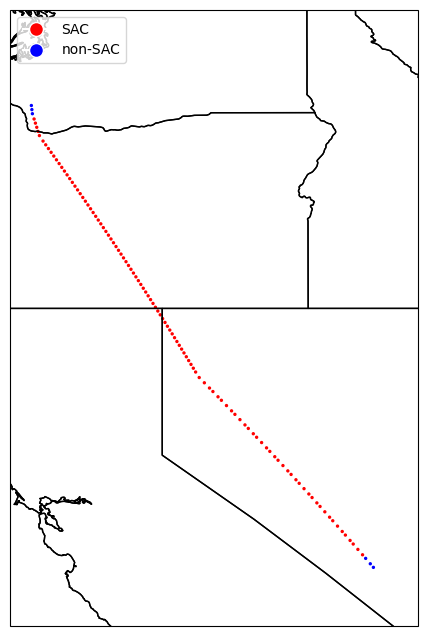

In [15]:
# Plot SAC along flight path
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

# Create colormap with red for SAC and blue for non-SAC
cmap = ListedColormap(["b", "r"])

# Plot flight waypoints
ax.scatter(
    fl_sac["longitude"], 
    fl_sac["latitude"], 
    c=fl_sac["sac"],
    s=2,
    transform=ccrs.PlateCarree(), 
    cmap=cmap
)

# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", label="SAC", markerfacecolor="r", markersize=10),
    plt.Line2D(
        [0], [0], marker="o", color="w", label="non-SAC", markerfacecolor="b", markersize=10
    ),
]
ax.legend(handles=legend_elements, loc="upper left");

## Calculate ice supersaturation along (ISSR) flight flight waypoints

[pycontrails.models.issr](https://py.contrails.org/api/pycontrails.models.issr.html)

In [16]:
from pycontrails.models.issr import ISSR
from pycontrails.models.humidity_scaling import ExponentialBoostLatitudeCorrectionHumidityScaling

In [17]:
# ISSR model inputs
# https://py.contrails.org/api/pycontrails.models.issr.html#pycontrails.models.issr.ISSRParams
params = {
    "humidity_scaling": ExponentialBoostLatitudeCorrectionHumidityScaling()
}

# Set up model
issr = ISSR(
    met=met,
    params=params
)

# Run model
fl_issr = issr.eval(source=flight)

In [18]:
# Get the length of the Flight in the ISSR region (in km)
fl_issr.length_met("issr") / 1e3

1019.272475885617

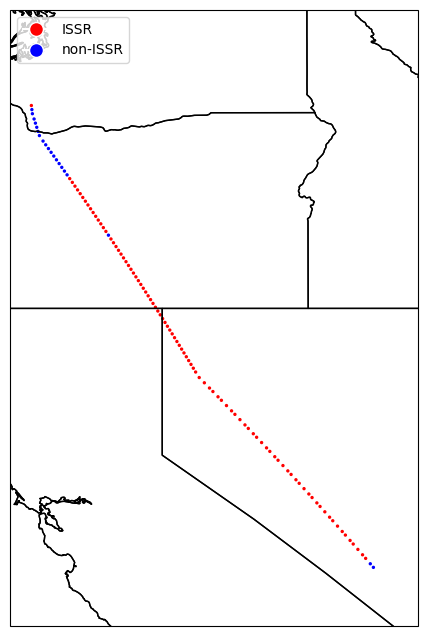

In [19]:
# Plot ISSR along flight
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

# Create colormap with red for ISSR and blue for non-ISSR
cmap = ListedColormap(["b", "r"])

# Plot flight waypoints
ax.scatter(
    fl_issr["longitude"], 
    fl_issr["latitude"], 
    c=fl_issr["issr"],
    s=2,
    transform=ccrs.PlateCarree(), 
    cmap=cmap
)

# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", label="ISSR", markerfacecolor="r", markersize=10),
    plt.Line2D(
        [0], [0], marker="o", color="w", label="non-ISSR", markerfacecolor="b", markersize=10
    ),
]
ax.legend(handles=legend_elements, loc="upper left")

## Run CoCiP along a single flight

[pycontrails.models.cocip.Cocip](https://py.contrails.org/api/pycontrails.models.cocip.Cocip.html)

In [20]:
from pycontrails.models.cocip import Cocip
from pycontrails.models.ps_model import PSFlight
from pycontrails.models.humidity_scaling import ExponentialBoostLatitudeCorrectionHumidityScaling

In [21]:
# CoCiP requires an `aircraft_type` on the input Flight
flight.attrs["aircraft_type"] = "A320"

# CoCiP model parameters
# https://py.contrails.org/api/pycontrails.models.cocip.CocipParams.html#pycontrails.models.cocip.CocipParams
params = {
    "dt_integration": np.timedelta64(10, "m"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # See https://py.contrails.org/api/pycontrails.models.humidity_scaling.html#module-pycontrails.models.humidity_scaling
    "humidity_scaling": ExponentialBoostLatitudeCorrectionHumidityScaling(),
    # Use Poll-Schumann aircraft performance model adapted for grid calculations
    # See https://py.contrails.org/api/pycontrails.models.ps_model.PSGrid.html#pycontrails.models.ps_model.PSGrid
    "aircraft_performance": PSFlight(),
}
# Set up model
cocip = Cocip(met=met, rad=rad, params=params)

In [22]:
# Run model
fl_cocip = cocip.eval(source=flight)

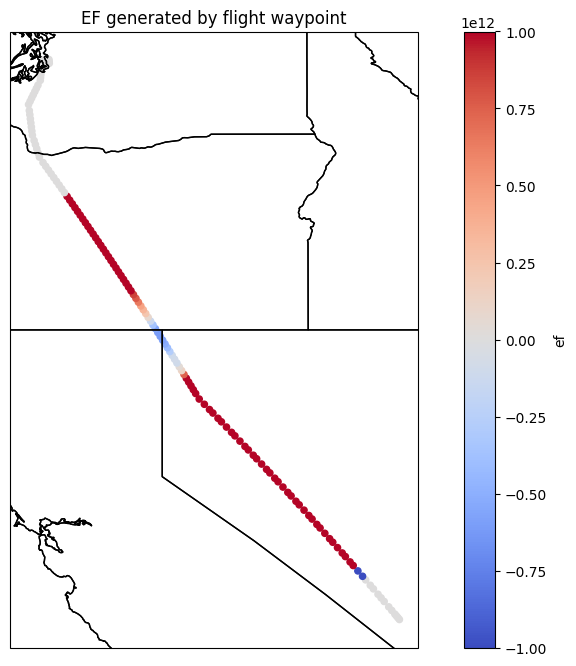

In [23]:
# Explore output
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

fl_cocip.dataframe.plot.scatter(
    x="longitude",
    y="latitude",
    c="ef",
    cmap="coolwarm",
    vmin=-1e12,
    vmax=1e12,
    ax=ax,
    title="EF generated by flight waypoint",
);

In [24]:
# Contrail properties are stored on the `.contrail` property of the Cocip model object
# This is a dataframe keyed by flight_id and waypoint
contrail = cocip.contrail
contrail.head()

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,tau_contrail,dn_dt_agg,dn_dt_turb,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours
0,12,190201-100870-DAL2791,2019-02-01 21:36:00,2019-02-01 21:40:00,0 days 00:04:00,-115.859437,36.967522,10334.663554,251.092213,True,...,0.215660,9.248572e-18,0.000056,-18.273138,5.113059,-13.160080,True,-5.027889e+09,0,0.066667
1,13,190201-100870-DAL2791,2019-02-01 21:37:10,2019-02-01 21:40:00,0 days 00:02:50,-115.969036,37.077181,10332.948638,251.158793,True,...,0.257514,9.415363e-18,0.000069,-21.482183,5.422153,-16.060032,True,-3.407378e+09,0,0.047222
2,14,190201-100870-DAL2791,2019-02-01 21:38:19,2019-02-01 21:40:00,0 days 00:01:41,-116.078035,37.186105,10330.421477,251.256934,True,...,0.274887,9.097070e-18,0.000096,-23.594683,4.953757,-18.640926,True,-1.228868e+09,0,0.028056
3,15,190201-100870-DAL2791,2019-02-01 21:39:05,2019-02-01 21:40:00,0 days 00:00:00,-116.150541,37.258323,10328.890801,251.316392,False,...,0.253535,8.394577e-18,0.000110,-22.374191,4.000708,-18.373484,True,0.000000e+00,0,0.000000
4,12,190201-100870-DAL2791,2019-02-01 21:36:00,2019-02-01 21:50:00,0 days 00:14:00,-115.743520,36.977642,10351.104579,250.454632,True,...,0.162508,1.103869e-17,0.000024,-13.423160,5.213959,-8.209200,True,-2.697187e+10,1,0.233333


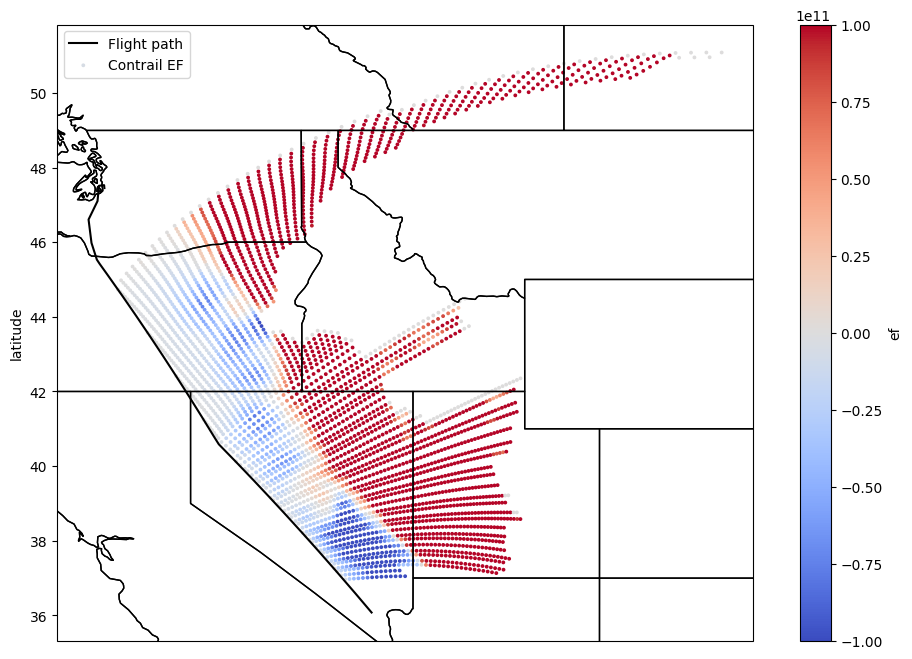

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

flight.dataframe.plot(
    x="longitude",
    y="latitude",
    color="k",
    ax=ax,
    label="Flight path",
)
cocip.contrail.plot.scatter(
    x="longitude",
    y="latitude",
    c="ef",
    cmap="coolwarm",
    vmin=-1e11,
    vmax=1e11,
    ax=ax,
    s=3,
    label="Contrail EF",
)
ax.legend();

### Run CoCiP along multiple flights

In [26]:
from pycontrails import Fleet

In [27]:
# Create a Fleet object from list of 100 flights
# Here we just say that all flights are A320s
flights = [Flight(gp, attrs={"aircraft_type": "A320"}) for fid, gp in df.groupby("flight_id")]
fleet = Fleet.from_seq(flights)

In [28]:
# Run CoCiP across the whole fleet (more efficient)
params = {
    "dt_integration": np.timedelta64(10, "m"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # See https://py.contrails.org/api/pycontrails.models.humidity_scaling.html#module-pycontrails.models.humidity_scaling
    "humidity_scaling": ExponentialBoostLatitudeCorrectionHumidityScaling(),
    # Use Poll-Schumann aircraft performance model adapted for grid calculations
    # See https://py.contrails.org/api/pycontrails.models.ps_model.PSGrid.html#pycontrails.models.ps_model.PSGrid
    "aircraft_performance": PSFlight(),
}
# Set up model
cocip_fleet = Cocip(met=met, rad=rad, params=params)

In [29]:
# Evaluate cocip on all 100 flights in parallel
output_fleet = cocip_fleet.eval(source=fleet)

/Users/marcshapiro/computing/contrailcirrus/pycontrails/pycontrails/physics/jet.py:331: RuntimeWarning: Mean of empty slice
  ff_end_of_cruise = np.nanmean(fuel_flow).item()
/Users/marcshapiro/computing/contrailcirrus/pycontrails/pycontrails/models/cocip/cocip.py:2315: UserWarning: At time 2019-02-02T12:10:00.000000, the contrail has no intersection with the met data. This is likely due to the contrail being advected outside the met domain.
  warnings.warn(


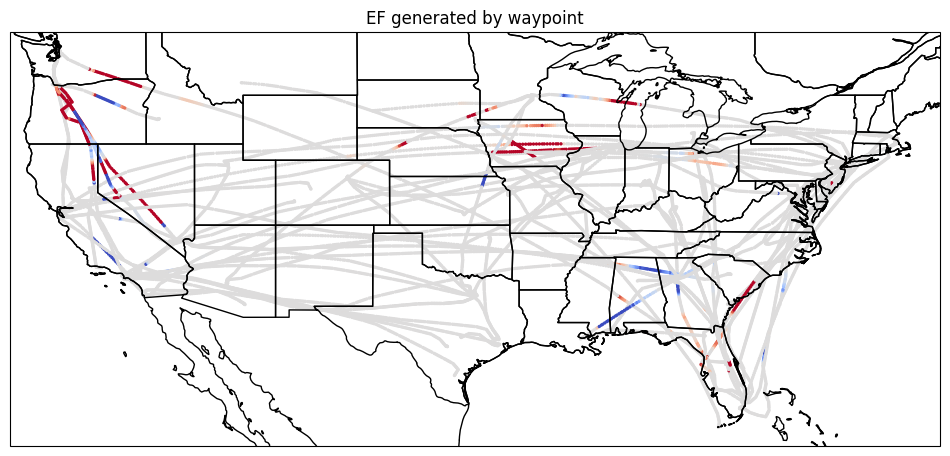

In [30]:
# Visualize the "ef" of each flight
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

for fl in output_fleet.to_flight_list():
    fl.dataframe.plot.scatter(
        x="longitude",
        y="latitude",
        c="ef",
        cmap="coolwarm",
        vmin=-1e12,
        vmax=1e12,
        s=2,
        title="EF generated by waypoint",
        ax=ax,
        colorbar=False,
    )


## Run CoCiP Grid forecast model

In [32]:
from pycontrails.models.cocipgrid import CocipGrid
from pycontrails.models.ps_model import PSGrid
from pycontrails.models.humidity_scaling import ExponentialBoostLatitudeCorrectionHumidityScaling

In [33]:
# CoCiP Grid Model parameters
# https://py.contrails.org/api/pycontrails.models.cocip.CocipParams.html#pycontrails.models.cocip.CocipParams
params = {
    "dt_integration": np.timedelta64(5, "m"),
    "max_age": np.timedelta64(10, "h"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # See https://py.contrails.org/api/pycontrails.models.humidity_scaling.html#module-pycontrails.models.humidity_scaling
    "humidity_scaling": ExponentialBoostLatitudeCorrectionHumidityScaling(),
    # Use Poll-Schumann aircraft performance model adapted for grid calculations
    # See https://py.contrails.org/api/pycontrails.models.ps_model.PSGrid.html#pycontrails.models.ps_model.PSGrid
    "aircraft_performance": PSGrid(),
}

# Initialize CocipGrid model
cocip_grid = CocipGrid(met=met, rad=rad, params=params)

In [34]:
# Create a grid source
coords = {
    "level": (300, 250, 200),  # hPa,
    "time": pd.date_range(DATE, DATE + pd.Timedelta("2h"), freq="1h"),
    "longitude": np.arange(CONUS[0], CONUS[1], 0.25),
    "latitude": np.arange(CONUS[2], CONUS[3], 0.25),
}
grid_source = MetDataset.from_coords(**coords)

# Run CocipGrid model
grid_output = cocip_grid.eval(source=grid_source)

CocipGrid eval:   0%|          | 0/46 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/contrails/lib/python3.11/site-packages/scipy/optimize/_zeros_py.py:479: RuntimeWarning: some failed to converge after 10 iterations
  warnings.warn(msg, RuntimeWarning)


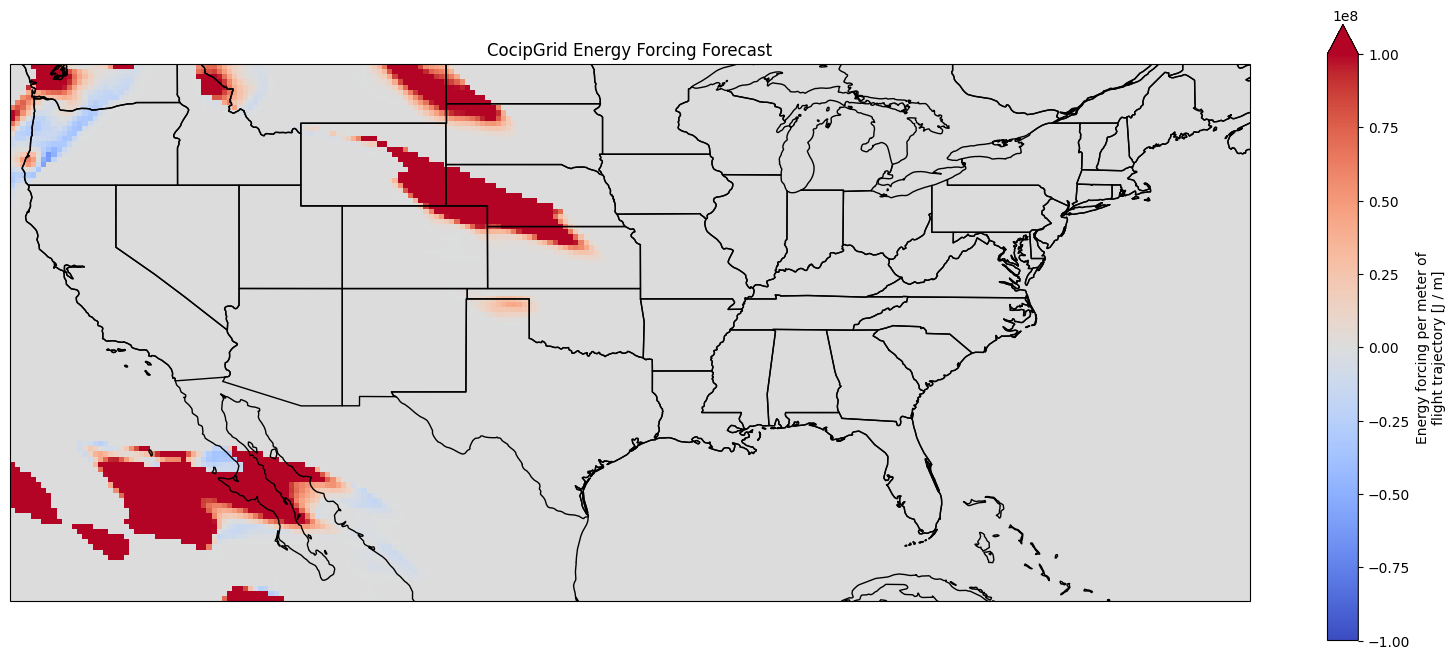

In [35]:
# Plot results
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

ef_per_m = grid_output.data["ef_per_m"].isel(time=0, level=0)
ef_per_m.plot(x="longitude", y="latitude", vmin=-1e8, vmax=1e8, cmap="coolwarm")

plt.title("CocipGrid Energy Forcing Forecast")
plt.xlabel("Longitude")
plt.ylabel("Latitude");